In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


In [8]:
train_path = 'cats-and-dogs/train'
valid_path = 'cats-and-dogs/valid'
test_path = 'cats-and-dogs/test'

In [9]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dog', 'cat'], batch_size = 10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['dog', 'cat'], batch_size = 4)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['dog', 'cat'], batch_size = 10)

Found 40 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [10]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [17]:
imgs, labels = next(train_batches)

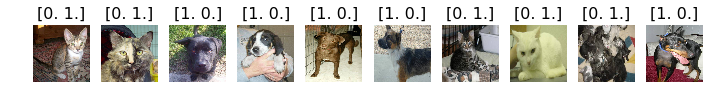

In [18]:
plots(imgs, titles=labels)

# Build and train CNN

In [20]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
    Flatten(),
    Dense(2, activation='softmax')   
])

In [22]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.fit_generator(train_batches, steps_per_epoch=4, 
                   validation_data=valid_batches, validation_steps=4,
                   epochs=5, verbose=2)

Epoch 1/5
 - 1s - loss: 9.3001 - acc: 0.4000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/5
 - 1s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/5
 - 1s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/5
 - 1s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/5
 - 1s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000


## Note, .fit_generator is for batch by batch fitting. .fit is for single batches.